# Gesture Recognition

### To Determine 
- Thumps Up
    - Increase Volume
- Thumps Down
    - Decrease Volume
- Left Swipe
    - 'Jump' backward 10 seconds
- Right Swipe
    - 'Jump' forward 10 seconds
- Stop
    - Pause the Video

## Objective
To build a model that predict the gesture and perform action.

In [1]:
# Importing Library

import numpy as np
import os
from imageio import imread
from skimage.transform import resize as imresize
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

Setting Random seed for result doen't vary drastically


In [2]:
# Importing Library

np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

Plotting graph

In [3]:
# Import Library

import matplotlib.pyplot as plt
import seaborn as sns

### Step: 1
#### Reading Dataset

In [4]:
# Providing Train and Validation dataset path.
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

### Step: 2
#### Defining Functions

Defining Function for Creating Plot

In [5]:
# Defining function
def plot(history):
    # Creating subplot
    
    fig, axes = plt.subplots(1,2, figsize=(20,10))
    # Accuracy
    axes[0].plot(history.history['categorical_accuracy'])
    axes[0].plot(history.history['val_categorical_accuracy'])
    axes[0].legend(["Train_Accuracy", "Val_Accuracy"], loc='upper right')
    
    
    # Loss
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].legend(["Train_Loss", "Val_Loss"], loc='upper right')
    
    
    # Show
    plt.show()

Defining Function for Normalize Image

In [6]:
# Defining function
def normalize_img(image):
    normalize_img = image/255
    return normalize_img

Defining Function for Resizing and Cropping Image

In [7]:
# Defining function
def crop_resize_image(image):
    if image.shape[0] == 120:
        image = imresize(image[:,20:140,:], (100,100)).astype(np.float32)
    else:
        image = imresize(image, (100, 100)).astype(np.float32)
    return image

Defining Function for Accuracy

In [8]:
# Defining function
def Model_acc(history):
    print("Maximum Training Accuracy: ", max(history.history['categorical_accuracy']))
    print("Maximum Validation Accuracy: ", max(history.history['val_categorical_accuracy']))

Defining Function for Generator

In [9]:
# Defining functions
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # Each folder is having 30 image
    img_idx = [i for i in range(1,30,2)]
    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = len(t)//batch_size 
        # Number of image // batch size
        # Example if Image has 58 img and batch size is 5
        # num_batch will be 11, 3 image goes to next batch 
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,15,100,100,3)) 
            # 15 is the number of images you use for each video, 
            # (100,100) is the final size of the input images 
            # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all image in folder
                
                for idx,item in enumerate(img_idx): 
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Cropping and resizing image
                    image = crop_resize_image(image)
                    
                    batch_data[folder,idx,:,:,0] = normalize_img(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = normalize_img(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = normalize_img(image[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,15,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Cropping and resizing image
                    image = crop_resize_image(image)
                    
                    batch_data[folder,idx,:,:,0] = normalize_img(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = normalize_img(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = normalize_img(image[:,:,2])
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D`. Also remember that the last layer is the softmax. Remember that the network is designed in such a way that the model is able to fit in the memory of the webcam.

In [10]:
# Impoting Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

# Conv3D
## Model - 1 

- Number of Epoch -> 10
- Batch Size -> 100

In [61]:
# Model - 1 
model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))


model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))


model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [62]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 10
print ('# Epochs =', num_epochs)
batch_size = 100
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 10
# Batch Size = 100


### Compiling Model and Model Summary

In [63]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss=tf.keras.losses.categorical_crossentropy, metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 100, 100, 64)  5248      
_________________________________________________________________
batch_normalization_18 (Batc (None, 15, 100, 100, 64)  256       
_________________________________________________________________
activation (Activation)      (None, 15, 100, 100, 64)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 50, 64)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 50, 128)    221312    
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 50, 50, 128)    512       
_________________________________________________________________
activation_1 (Activation)    (None, 8, 50, 50, 128)   

In [64]:
# Creating Generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [65]:
# Model Name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [66]:
# Steps for training and validation
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [17]:
# # Fitting into model
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 100
Epoch 1/10


ResourceExhaustedError:  OOM when allocating tensor with shape[100,64,15,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/max_pooling3d/MaxPool3D (defined at <ipython-input-17-48d605799500>:4) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_1540]

Function call stack:
train_function


# Conclusion
Throwing Error
--------------
"OOM when allocating tensor with shape[100,64,15,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential/max_pooling3d/MaxPool3D (defined at <ipython-input-17-48d605799500>:4) ]]"

# Model - 2

- Number of Epoch -> 10
- Batch Size -> 50

In [18]:
# Model - 2 
model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))


model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))


model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [19]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 10
print ('# Epochs =', num_epochs)
batch_size = 50
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 10
# Batch Size = 50


### Compiling Model and Model Summary

In [20]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss=tf.keras.losses.categorical_crossentropy, metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 100, 100, 64)  5248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 100, 100, 64)  256       
_________________________________________________________________
activation_4 (Activation)    (None, 15, 100, 100, 64)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 50, 50, 64)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 50, 50, 128)    221312    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 50, 50, 128)    512       
_________________________________________________________________
activation_5 (Activation)    (None, 8, 50, 50, 128)   

In [21]:
# Creating Generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
# Model Name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [23]:
# Steps for training and validation
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
# Fitting into model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 50
Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 3.0260 - categorical_accuracy: 0.2911Source path =  /home/datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to model_init_2021-08-3107_03_31.869183/model-00001-3.02598-0.29110-1.60113-0.22000.h5
14/14 [==============================] - 79s 6s/step - loss: 3.0260 - categorical_accuracy: 0.2911 - val_loss: 1.6011 - val_categorical_accuracy: 0.2200
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 1.5986 - categorical_accuracy: 0.4404
Epoch 00002: saving model to model_init_2021-08-3107_03_31.869183/model-00002-1.59865-0.44042-1.71237-0.20000.h5
14/14 [==============================] - 76s 5s/step - loss: 1.5986 - categorical_accuracy: 0.4404 - val_loss: 1.7124 - val_categorical_accuracy: 0.2000
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 1.2786 - categorical_accuracy: 0.5309
Epoch 00003: savin

## Best Accuracy

In [25]:
Model_acc(history)

Maximum Training Accuracy:  0.698340892791748
Maximum Validation Accuracy:  0.27000001072883606


### Conclusion
- Badly Overfitter model as Training Accuracy is much higher than Validation Accuracy
- Model is not learning any thing as Validation Accuracy is very low

### Plotting graph

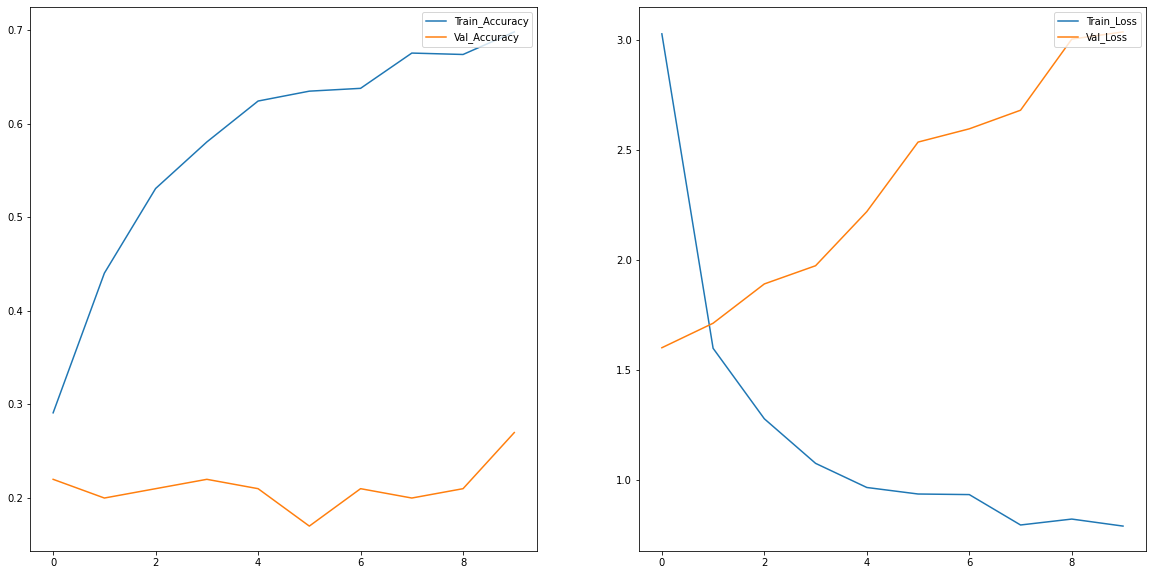

In [26]:
plot(history)

# Model - 3

- Number of Epoch -> 20
- Batch Size -> 30

In [27]:
# Model - 3 
model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))


model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))


model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [28]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 20
print ('# Epochs =', num_epochs)
batch_size = 30
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 20
# Batch Size = 30


### Compiling Model and Model Summary

In [29]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss=tf.keras.losses.categorical_crossentropy, metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 15, 100, 100, 64)  5248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 100, 100, 64)  256       
_________________________________________________________________
activation_8 (Activation)    (None, 15, 100, 100, 64)  0         
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 50, 50, 64)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 50, 50, 128)    221312    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 50, 50, 128)    512       
_________________________________________________________________
activation_9 (Activation)    (None, 8, 50, 50, 128)   

In [30]:
# Creating Generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
# Model Name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [32]:
# Steps for training and validation
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
# Fitting into model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 2.6959 - categorical_accuracy: 0.3288Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-08-3107_19_36.693151/model-00001-2.69591-0.32881-1.68178-0.17000.h5
23/23 [==============================] - 79s 3s/step - loss: 2.6959 - categorical_accuracy: 0.3288 - val_loss: 1.6818 - val_categorical_accuracy: 0.1700
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 1.6877 - categorical_accuracy: 0.4525
Epoch 00002: saving model to model_init_2021-08-3107_19_36.693151/model-00002-1.68774-0.45249-1.93798-0.20000.h5
23/23 [==============================] - 82s 4s/step - loss: 1.6877 - categorical_accuracy: 0.4525 - val_loss: 1.9380 - val_categorical_accuracy: 0.2000
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.3373 - categorical_accuracy: 0.5098
Epoch 00003: savin

## Best Accuracy

In [34]:
Model_acc(history)

Maximum Training Accuracy:  0.7164404392242432
Maximum Validation Accuracy:  0.25


### Conclusion
- Badly Overfitter model as Training Accuracy is much higher than Validation Accuracy
- Model is not learning any thing as Validation Accuracy is very low

### Plotting graph

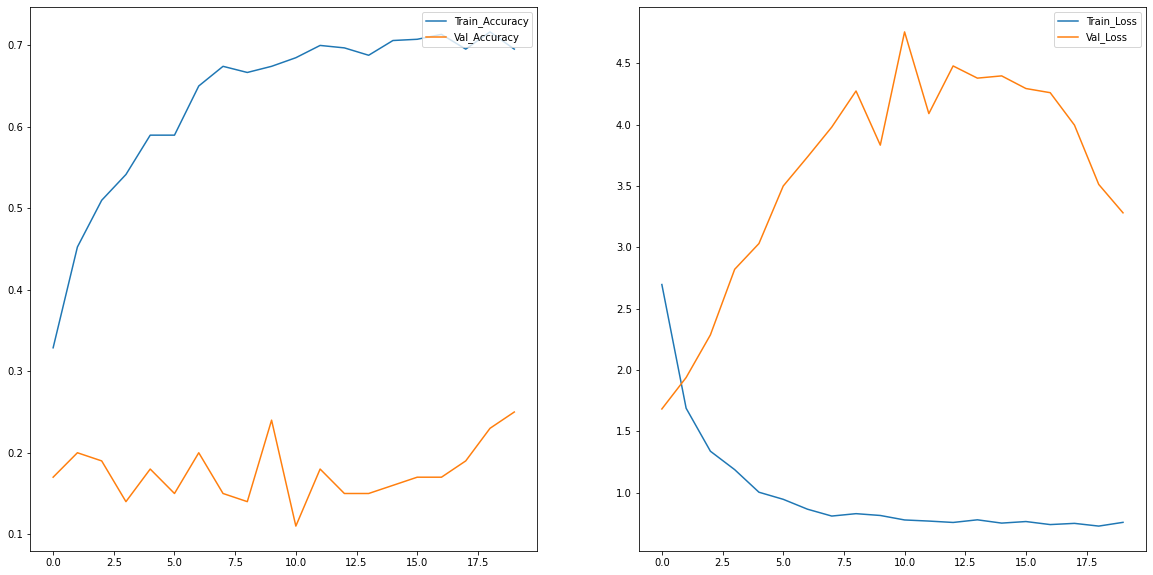

In [35]:
plot(history)

# Model - 4

- Number of Epoch -> 20
- Batch Size -> 30
- Reducing Number of variables
- Adding Dropout

In [53]:
# Model - 4 
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(15,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))


model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [54]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 20
print ('# Epochs =', num_epochs)
batch_size = 30
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 20
# Batch Size = 30


### Compiling Model and Model Summary

In [55]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss=tf.keras.losses.categorical_crossentropy, metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 15, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 100, 100, 16)  64        
_________________________________________________________________
activation_16 (Activation)   (None, 15, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 8, 50, 50, 32)     13856     
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 50, 50, 32)     128       
_________________________________________________________________
activation_17 (Activation)   (None, 8, 50, 50, 32)    

In [56]:
# Creating Generator
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [57]:
# Model Name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [58]:
# Steps for training and validation
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [59]:
# Fitting into model
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 3.3245 - categorical_accuracy: 0.2157Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: saving model to model_init_2021-08-3108_17_03.985082/model-00001-3.32448-0.21569-1.60771-0.22000.h5
23/23 [==============================] - 76s 3s/step - loss: 3.3245 - categorical_accuracy: 0.2157 - val_loss: 1.6077 - val_categorical_accuracy: 0.2200
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 2.0011 - categorical_accuracy: 0.2383
Epoch 00002: saving model to model_init_2021-08-3108_17_03.985082/model-00002-2.00112-0.23831-1.61541-0.17000.h5
23/23 [==============================] - 75s 3s/step - loss: 2.0011 - categorical_accuracy: 0.2383 - val_loss: 1.6154 - val_categorical_accuracy: 0.1700
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 1.7615 - categorical_accuracy: 0.2715
Epoch 00003: savin

## Best Accuracy

In [60]:
Model_acc(history)

Maximum Training Accuracy:  0.3559577763080597
Maximum Validation Accuracy:  0.28999999165534973


### Plotting graph

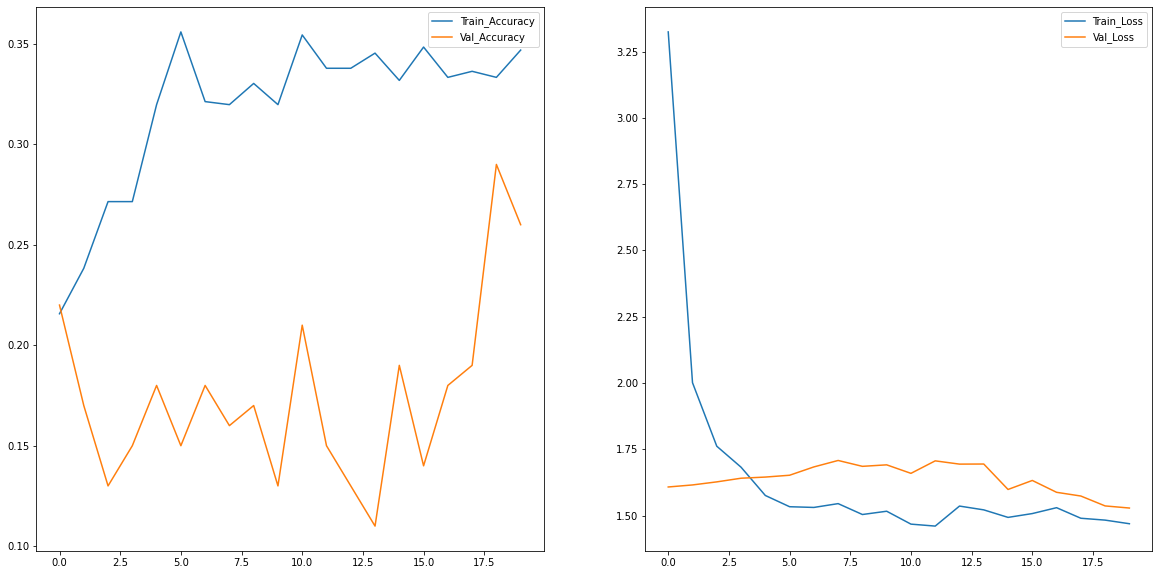

In [61]:
plot(history)

### Conclusion
- Model is not learning

# Model - 5

- Number of Epoch -> 30
- Batch Size -> 20
- Increasing Number of frame in each video
- Reducing convolution layer
- Reducing Filtersize

In [11]:
# Defining functions
def generator_1(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # Each folder is having 30 image
    img_idx = [0,2,4,6,7,9,10,11,12,14,15,16,17,18,19,21,22,24,25,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = len(t)//batch_size 
        # Number of image // batch size
        # Example if Image has 58 img and batch size is 5
        # num_batch will be 11, 3 image goes to next batch 
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,22,100,100,3)) 
            # 22 is the number of images you use for each video, 
            # (100,100) is the final size of the input images 
            # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all image in folder
                
                for idx,item in enumerate(img_idx): 
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Cropping and resizing image
                    image = crop_resize_image(image)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,22,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Cropping and resizing image
                    image = crop_resize_image(image)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels
        # write the code for the remaining data points which are left after full batches

In [64]:
# Model - 5 
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(22,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [65]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 30
print ('# Epochs =', num_epochs)
batch_size = 20
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 30
# Batch Size = 20


### Compiling Model and Model Summary

In [66]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 22, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_20 (Batc (None, 22, 100, 100, 16)  64        
_________________________________________________________________
activation_20 (Activation)   (None, 22, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 11, 50, 50, 16)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 11, 50, 50, 32)    4128      
_________________________________________________________________
batch_normalization_21 (Batc (None, 11, 50, 50, 32)    128       
_________________________________________________________________
activation_21 (Activation)   (None, 11, 50, 50, 32)   

In [67]:
# Creating Generator
train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

In [68]:
# Model Name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [69]:
# Steps for training and validation
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [70]:
# Fitting into model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.3638 - categorical_accuracy: 0.2519Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2021-08-3108_54_07.376857/model-00001-2.36377-0.25189-1.64285-0.23000.h5
34/34 [==============================] - 124s 4s/step - loss: 2.3638 - categorical_accuracy: 0.2519 - val_loss: 1.6429 - val_categorical_accuracy: 0.2300
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.7203 - categorical_accuracy: 0.2504
Epoch 00002: saving model to model_init_2021-08-3108_54_07.376857/model-00002-1.72033-0.25038-1.64418-0.27000.h5
34/34 [==============================] - 119s 4s/step - loss: 1.7203 - categorical_accuracy: 0.2504 - val_loss: 1.6442 - val_categorical_accuracy: 0.2700
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.5785 - categorical_accuracy: 0.2821
Epoch 00003: sav

## Best Accuracy

In [71]:
Model_acc(model.history)

Maximum Training Accuracy:  0.5671191811561584
Maximum Validation Accuracy:  0.7799999713897705


### Conlusion
- Surprisingly model Accuracy is greater than Training Accuracy

### Plotting graph

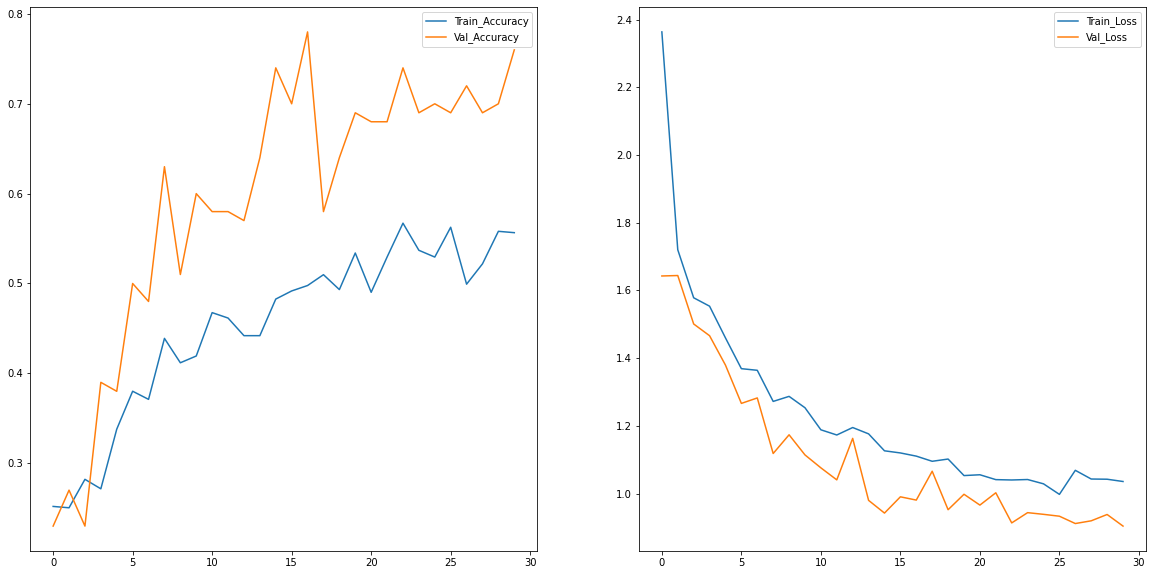

In [72]:
history = model.history
plot(history)

# Model - 6

- Number of Epoch -> 30
- Batch Size -> 20
- Increasing Neurons

In [73]:
# Model - 6 
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(22,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [74]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 30
print ('# Epochs =', num_epochs)
batch_size = 20
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 30
# Batch Size = 20


### Compiling Model and Model Summary

In [75]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 22, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization_24 (Batc (None, 22, 100, 100, 16)  64        
_________________________________________________________________
activation_24 (Activation)   (None, 22, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 11, 50, 50, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 11, 50, 50, 32)    4128      
_________________________________________________________________
batch_normalization_25 (Batc (None, 11, 50, 50, 32)    128       
_________________________________________________________________
activation_25 (Activation)   (None, 11, 50, 50, 32)   

In [76]:
# Creating Generator
train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

In [77]:
# Model Name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [78]:
# Steps for training and validation
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [79]:
# Fitting into model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.6019 - categorical_accuracy: 0.2278Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2021-08-3109_53_28.767376/model-00001-2.60189-0.22775-1.56275-0.26000.h5
34/34 [==============================] - 109s 3s/step - loss: 2.6019 - categorical_accuracy: 0.2278 - val_loss: 1.5628 - val_categorical_accuracy: 0.2600
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6734 - categorical_accuracy: 0.2443
Epoch 00002: saving model to model_init_2021-08-3109_53_28.767376/model-00002-1.67344-0.24434-1.57718-0.29000.h5
34/34 [==============================] - 108s 3s/step - loss: 1.6734 - categorical_accuracy: 0.2443 - val_loss: 1.5772 - val_categorical_accuracy: 0.2900
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.6223 - categorical_accuracy: 0.2534
Epoch 00003: sav

## Best Accuracy

In [80]:
Model_acc(model.history)

Maximum Training Accuracy:  0.5022624731063843
Maximum Validation Accuracy:  0.6800000071525574


### Conclusion
- Accuracy is low

### Plotting graph

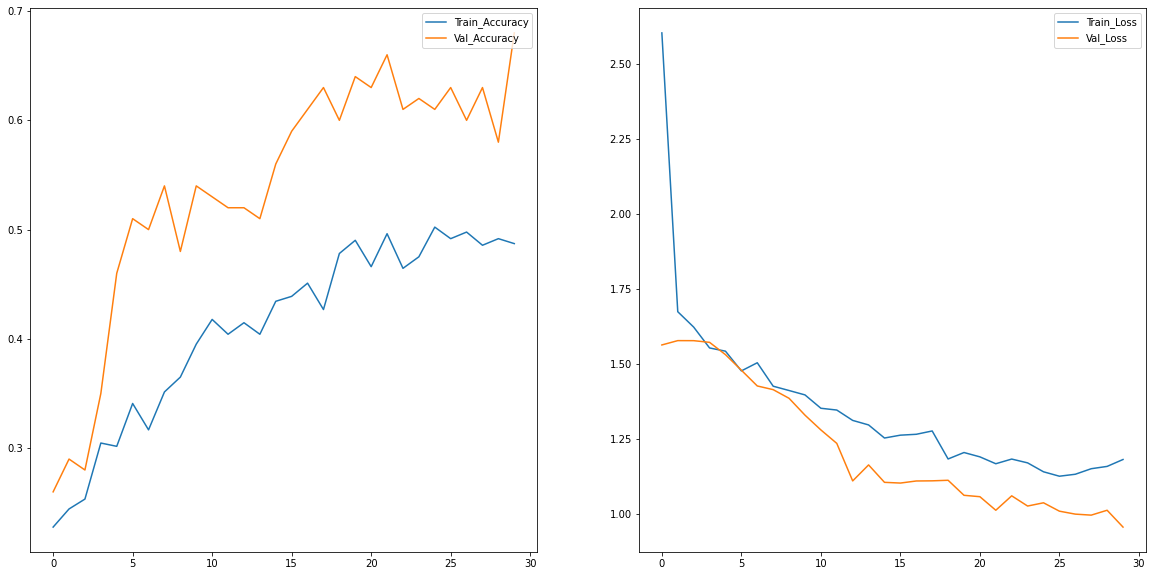

In [81]:
history = model.history
plot(history)

# Model - 7

- Adding Strides

In [12]:
# Model - 1 
model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(22,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 30
print ('# Epochs =', num_epochs)
batch_size = 20
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 30
# Batch Size = 20


### Compiling Model and Model Summary

In [14]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 22, 100, 100, 16)  1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 22, 100, 100, 16)  64        
_________________________________________________________________
activation (Activation)      (None, 22, 100, 100, 16)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 11, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 11, 50, 50, 32)    4128      
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 50, 50, 32)    128       
_________________________________________________________________
activation_1 (Activation)    (None, 11, 50, 50, 32)    0

In [15]:
# Creating Generator
train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

In [16]:
# Model Name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [17]:
# Steps for training and validation
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
# Fitting into model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.4192 - categorical_accuracy: 0.2459Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_2021-08-3111_04_16.343679/model-00001-2.41921-0.24585-1.69782-0.29000.h5
34/34 [==============================] - 103s 3s/step - loss: 2.4192 - categorical_accuracy: 0.2459 - val_loss: 1.6978 - val_categorical_accuracy: 0.2900
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6196 - categorical_accuracy: 0.2670
Epoch 00002: saving model to model_init_2021-08-3111_04_16.343679/model-00002-1.61958-0.26697-1.44195-0.27000.h5
34/34 [==============================] - 104s 3s/step - loss: 1.6196 - categorical_accuracy: 0.2670 - val_loss: 1.4419 - val_categorical_accuracy: 0.2700
Epoch 3/30
34/34 [============================

## Best Accuracy

In [19]:
Model_acc(model.history)

Maximum Training Accuracy:  0.4841628968715668
Maximum Validation Accuracy:  0.5799999833106995


### Coclusion
- Poor Accuracy

### Plotting graph

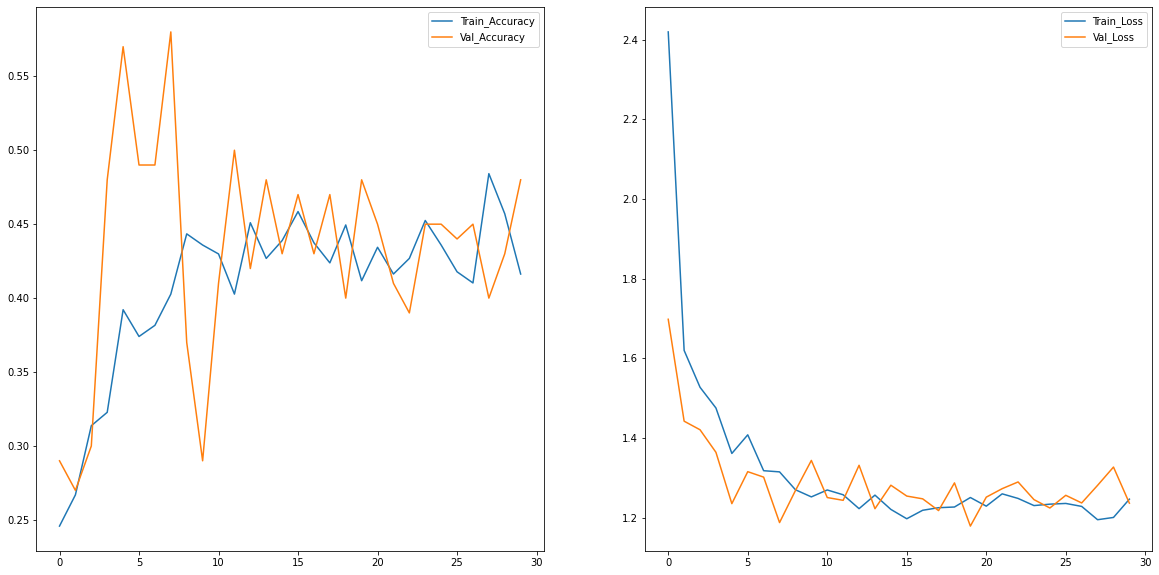

In [20]:
history = model.history
plot(history)

# Model - 8

- Number of Epoch -> 30
- Batch Size -> 25
- Reducing convolution layer
- Increasing Neurons

In [68]:
# Model - 1 
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(22,100,100,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2), padding='same'))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [69]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 30
print ('# Epochs =', num_epochs)
batch_size = 25
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 30
# Batch Size = 25


### Compiling Model and Model Summary

In [70]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 22, 100, 100, 32)  2624      
_________________________________________________________________
batch_normalization_22 (Batc (None, 22, 100, 100, 32)  128       
_________________________________________________________________
activation_4 (Activation)    (None, 22, 100, 100, 32)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 11, 50, 50, 32)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 11, 50, 50, 64)    16448     
_________________________________________________________________
batch_normalization_23 (Batc (None, 11, 50, 50, 64)    256       
_________________________________________________________________
activation_5 (Activation)    (None, 11, 50, 50, 64)   

In [71]:
# Creating Generator
train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

In [72]:
# Model Name
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [73]:
# Steps for training and validation
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [74]:
# Fitting into model
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 25
Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 2.4358 - categorical_accuracy: 0.2700Source path =  /home/datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2021-08-3118_46_44.525768/model-00001-2.43585-0.26998-2.17358-0.23000.h5
27/27 [==============================] - 103s 4s/step - loss: 2.4358 - categorical_accuracy: 0.2700 - val_loss: 2.1736 - val_categorical_accuracy: 0.2300
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 1.4094 - categorical_accuracy: 0.3741
Epoch 00002: saving model to model_init_2021-08-3118_46_44.525768/model-00002-1.40935-0.37406-2.22444-0.23000.h5
27/27 [==============================] - 102s 4s/step - loss: 1.4094 - categorical_accuracy: 0.3741 - val_loss: 2.2244 - val_categorical_accuracy: 0.2300
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 1.3157 - categorical_accuracy: 0.4072
Epoch 00003: sav

## Best Accuracy

In [75]:
Model_acc(model.history)

Maximum Training Accuracy:  0.8627451062202454
Maximum Validation Accuracy:  0.9300000071525574


### Conclusion
- Good Accuracy in both Training and Validation

### Plotting graph

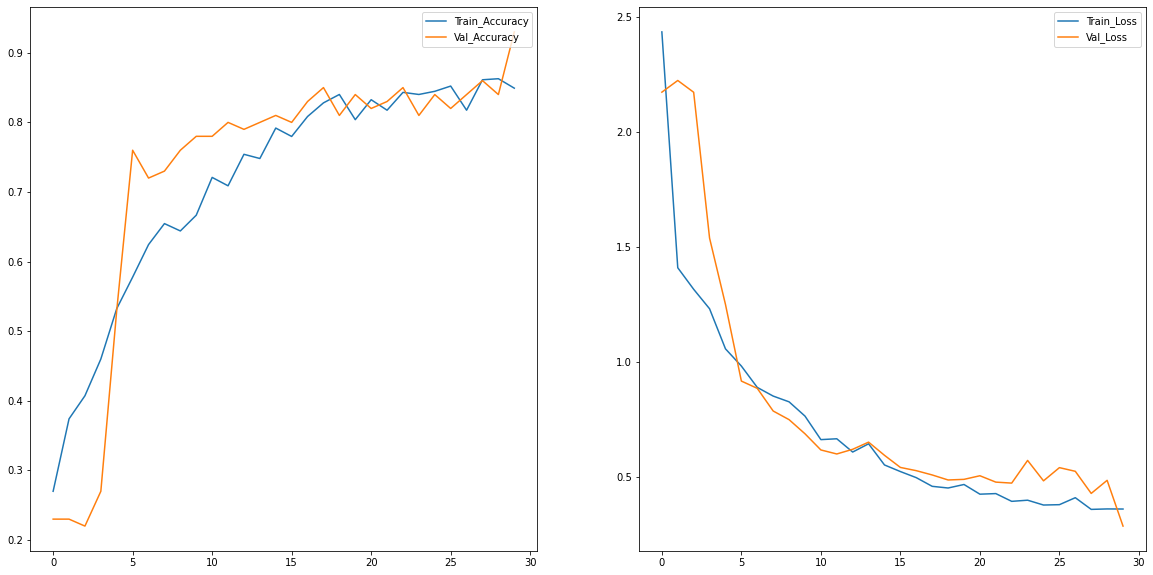

In [76]:
history = model.history
plot(history)

# CNN-RNN

## Model - 9
### CNN-LSTM

In [12]:
# Importing Library
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, TimeDistributed, LSTM, add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [14]:
# Model - 9
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), padding='same'), input_shape=(22,100,100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.25))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.25))
        
model.add(TimeDistributed(Flatten()))

model.add(LSTM(32,return_sequences=True))
model.add(LSTM(16))
model.add(Dropout(0.25))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

In [15]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 30
print ('# Epochs =', num_epochs)
batch_size = 25
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 30
# Batch Size = 25


In [16]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 22, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 22, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 22, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 22, 50, 50, 64)    18496     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 22, 50, 50, 64)    256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 22, 25, 25, 64)    0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 25, 25, 64)    0

In [17]:
train_generator = generator_1(train_path, train_doc, batch_size)
val_generator = generator_1(val_path, val_doc, batch_size)

In [18]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [20]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
Source path =  /home/datasets/Project_data/train ; batch size = 25
Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 1.6044 - categorical_accuracy: 0.2172Source path =  /home/datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_conv_lstm_2021-08-3116_12_20.513211/model-00001-1.60444-0.21719-1.59760-0.25000.h5
27/27 [==============================] - 103s 4s/step - loss: 1.6044 - categorical_accuracy: 0.2172 - val_loss: 1.5976 - val_categorical_accuracy: 0.2500
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 1.5572 - categorical_accuracy: 0.2700
Epoch 00002: saving model to model_init_conv_lstm_2021-08-3116_12_20.513211/model-00002-1.55720-0.26998-1.53988-0.25000.h5
27/27 [==============================] - 105s 4s/step - loss: 1.5572 - categorical_accuracy: 0.2700 - val_loss: 1.5399 - val_categorical_accuracy: 0.2500
Epoch 3/30
27/27 [========

## Model Accuracy

In [21]:
Model_acc(model.history)

Maximum Training Accuracy:  0.6334841847419739
Maximum Validation Accuracy:  0.5899999737739563


### Conclusion
- Poor Accuracy

## Plotting Graph

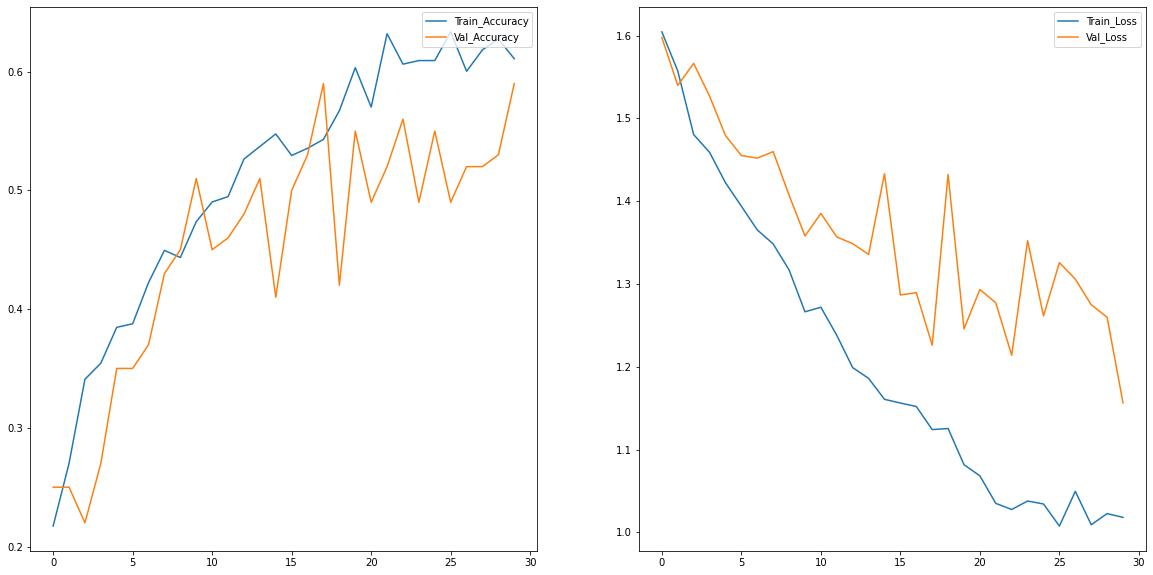

In [22]:
history = model.history
plot(history)

# Model - 10

- Adding more layer
- Reducing Epoch to 20
- Reducing Batch Size to 20
- Reducing Number of frame

In [13]:
# Defining functions
def generator_2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    # Each folder is having 30 image
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = len(t)//batch_size 
        # Number of image // batch size
        # Example if Image has 58 img and batch size is 5
        # num_batch will be 11, 3 image goes to next batch 
        
        for batch in range(num_batches): # we iterate over the number of batches
            
            batch_data = np.zeros((batch_size,18,100,100,3)) 
            # 18 is the number of images you use for each video, 
            # (100,100) is the final size of the input images 
            # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all image in folder
                
                for idx,item in enumerate(img_idx): 
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Cropping and resizing image
                    image = crop_resize_image(image)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    # Cropping and resizing image
                    image = crop_resize_image(image)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [24]:
# Model - 10
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(18,100,100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
        
model.add(Dense(5, activation='softmax'))

In [25]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 20
print ('# Epochs =', num_epochs)
batch_size = 20
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 20
# Batch Size = 20


In [26]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 18, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 18, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_12 (TimeDis (None, 18, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 18, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_15 (TimeDis (None, 18, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 18, 25, 25, 64)   

In [27]:
train_generator = generator_2(train_path, train_doc, batch_size)
val_generator = generator_2(val_path, val_doc, batch_size)

In [28]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [29]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [30]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.6130 - categorical_accuracy: 0.2519Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_conv_lstm_2021-08-3117_06_55.534464/model-00001-1.61304-0.25189-1.63076-0.23000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.6130 - categorical_accuracy: 0.2519 - val_loss: 1.6308 - val_categorical_accuracy: 0.2300
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4200 - categorical_accuracy: 0.4193
Epoch 00002: saving model to model_init_conv_lstm_2021-08-3117_06_55.534464/model-00002-1.42004-0.41931-1.60684-0.29000.h5
34/34 [==============================] - 86s 3s/step - loss: 1.4200 - categorical_accuracy: 0.4193 - val_loss: 1.6068 - val_categorical_accuracy: 0.2900
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3524 - categorical_accuracy: 0.463

## Model Accuracy

In [31]:
Model_acc(model.history)

Maximum Training Accuracy:  0.8763197660446167
Maximum Validation Accuracy:  0.7099999785423279


## Plotting Graph

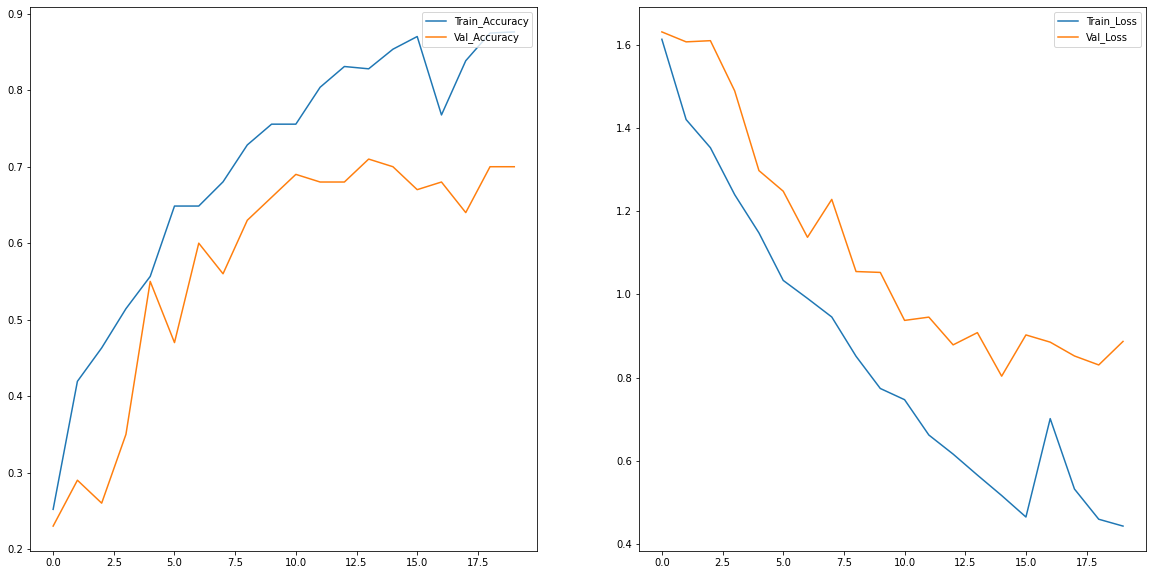

In [32]:
history = model.history
plot(history)

### Conclustion
- Slightly Overfitting

# Model - 11

- Adding Dropout

In [33]:
# Model - 10
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(18,100,100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.50))
        
model.add(Dense(5, activation='softmax'))

In [34]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 20
print ('# Epochs =', num_epochs)
batch_size = 20
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 20
# Batch Size = 20


In [35]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 18, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 18, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 18, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 18, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 18, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 18, 25, 25, 64)   

In [36]:
train_generator = generator_2(train_path, train_doc, batch_size)
val_generator = generator_2(val_path, val_doc, batch_size)

In [37]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [38]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [39]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7419 - categorical_accuracy: 0.2504Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_conv_lstm_2021-08-3117_40_16.403072/model-00001-1.74195-0.25038-1.59549-0.22000.h5
34/34 [==============================] - 119s 4s/step - loss: 1.7419 - categorical_accuracy: 0.2504 - val_loss: 1.5955 - val_categorical_accuracy: 0.2200
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.5796 - categorical_accuracy: 0.3137
Epoch 00002: saving model to model_init_conv_lstm_2021-08-3117_40_16.403072/model-00002-1.57961-0.31373-1.57527-0.29000.h5
34/34 [==============================] - 118s 3s/step - loss: 1.5796 - categorical_accuracy: 0.3137 - val_loss: 1.5753 - val_categorical_accuracy: 0.2900
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.4661 - categorical_accuracy: 0.3

## Model Accuracy

In [40]:
Model_acc(model.history)

Maximum Training Accuracy:  0.7993966937065125
Maximum Validation Accuracy:  0.7799999713897705


### Conclusion
- Good Accuracy for both Training And Validation

## Plotting Graph

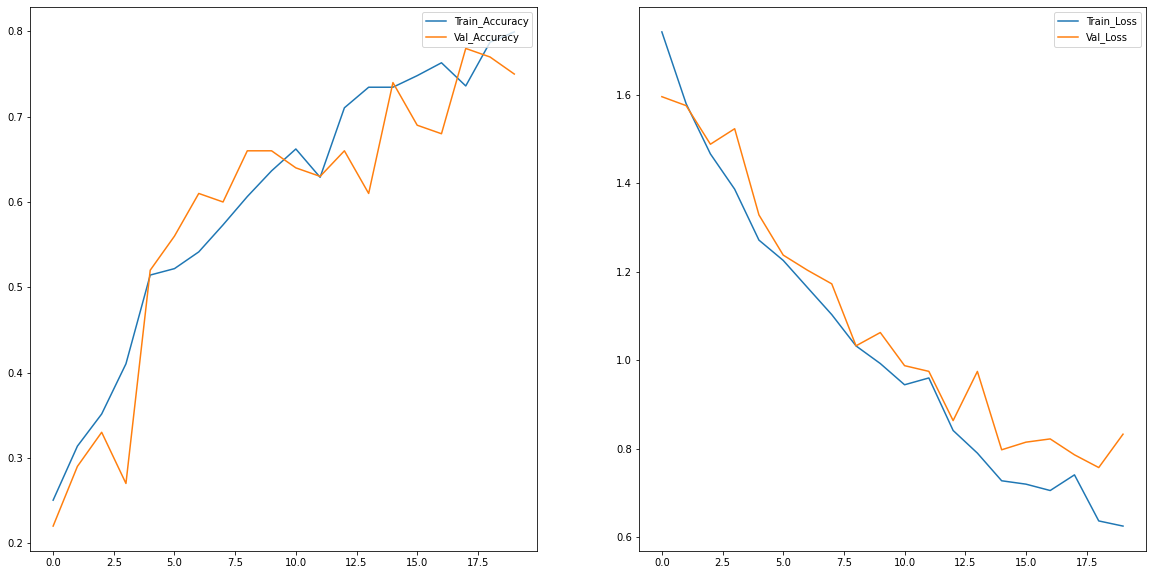

In [41]:
history = model.history
plot(history)

# Model - 12

### CNN-GRU

In [42]:
# Model - 10
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(18,100,100,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(GRU(64))
model.add(Dropout(0.25))
        
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.50))
        
model.add(Dense(5, activation='softmax'))

In [43]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# Training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# Validation sequences =', num_val_sequences)
num_epochs = 20
print ('# Epochs =', num_epochs)
batch_size = 20
print('# Batch Size =', batch_size)

# Training sequences = 663
# Validation sequences = 100
# Epochs = 20
# Batch Size = 20


In [44]:
# Compiler
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_42 (TimeDis (None, 18, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_43 (TimeDis (None, 18, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_44 (TimeDis (None, 18, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 18, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_46 (TimeDis (None, 18, 50, 50, 32)    128       
_________________________________________________________________
time_distributed_47 (TimeDis (None, 18, 25, 25, 32)    0         
_________________________________________________________________
time_distributed_48 (TimeDis (None, 18, 25, 25, 64)   

In [45]:
train_generator = generator_2(train_path, train_doc, batch_size)
val_generator = generator_2(val_path, val_doc, batch_size)

In [46]:
model_name = 'model_init_conv_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

In [47]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [48]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7538 - categorical_accuracy: 0.2730Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: saving model to model_init_conv_lstm_2021-08-3118_14_34.263574/model-00001-1.75375-0.27300-1.77430-0.23000.h5
34/34 [==============================] - 90s 3s/step - loss: 1.7538 - categorical_accuracy: 0.2730 - val_loss: 1.7743 - val_categorical_accuracy: 0.2300
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.4990 - categorical_accuracy: 0.3605
Epoch 00002: saving model to model_init_conv_lstm_2021-08-3118_14_34.263574/model-00002-1.49902-0.36048-1.81341-0.24000.h5
34/34 [==============================] - 89s 3s/step - loss: 1.4990 - categorical_accuracy: 0.3605 - val_loss: 1.8134 - val_categorical_accuracy: 0.2400
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.3597 - categorical_accuracy: 0.410

## Model Accuracy

In [49]:
Model_acc(model.history)

Maximum Training Accuracy:  0.8265460133552551
Maximum Validation Accuracy:  0.7799999713897705


### Conclusion
- Good Accuracy in both Training and Validation
- Less number of Parameters as compares to other model

## Plotting Graph

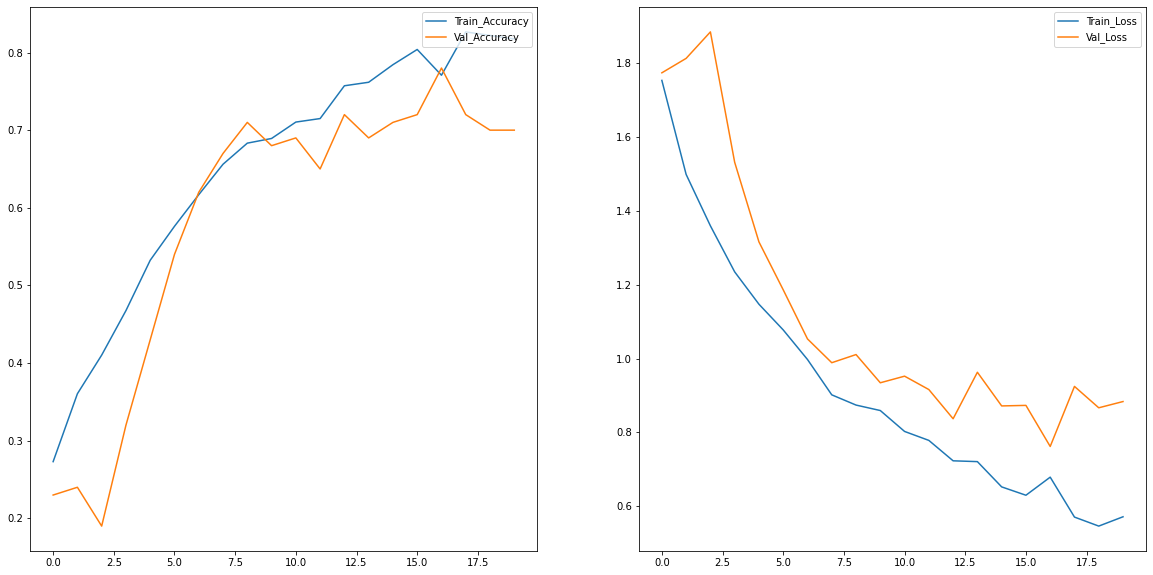

In [50]:
history = model.history
plot(history)